In [318]:
import os
import pandas as pd
import numpy as np

from IPython.display import Image
from subprocess import call

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

%matplotlib inline

In [345]:
# Paramns
load_model = False
replace_model = True

In [346]:
dataset = pd.read_csv('dataset_final_treat.csv')
dataset.head()

,stimul,3_seconds_before,max_variation_3_init,size_instantly_before_stimul,size_instantly_after_stimul,max_variation_end_3,3_seconds_after,max_variation_3_5,5_seconds_after,max_variation_5_6,6_seconds_after,max_variation_6_10,10_seconds_after,max_variation_10_15,15_seconds_after,classify
0,GREEN,NaN,75.499630,148.101109,86.564969,85.859824,77.413905,16.322670,79.548213,5.807754,75.612416,94.557429,NaN,36.423620,NaN,Alterado
1,WHITE,71.064351,16.322670,75.921845,40.385230,53.387231,58.089947,15.525845,63.182150,13.951668,74.125900,36.922826,90.458893,56.981451,NaN,Alterado
2,RED,91.930873,9.385295,92.801719,49.058049,35.653703,79.085347,7.341944,78.327185,30.556769,70.664204,83.370715,96.944942,126.174200,170.131519,Alterado
3,BLUE,103.827673,114.258446,135.622956,52.562305,77.406563,69.620100,18.853719,83.177519,3.867221,85.642825,68.658118,NaN,63.930862,NaN,Alterado
4,GREEN,73.363492,21.154029,86.163943,72.408206,60.984162,68.086146,22.232613,75.391691,43.118221,NaN,48.833691,NaN,7.567916,NaN,Alterado


In [347]:
# columns_drop = ['3_seconds_after', '15_seconds_after', 'max_value3', 'stimul', '3_seconds_before'] # Accuracy: 0.8539 (+/- 0.1527)
# columns_drop = ['min_value1','min_value2','min_value3','max_value1','max_value2','max_value3']
# columns_drop = ['6_seconds_after', 'max_variation_end_3']

columns_drop = ['3_seconds_before', 'size_instantly_before_stimul',
                'size_instantly_after_stimul', 'size_instantly_after_stimul',
                '3_seconds_after', '5_seconds_after', '6_seconds_after', '10_seconds_after',
                '15_seconds_after', ]


# columns_drop = ['6_seconds_after']

if len(columns_drop) > 0:
    dataset = dataset.drop(columns_drop, axis=1)

In [348]:
if 'stimul' in dataset.columns:
    mask = dataset.stimul.duplicated()
    print(dataset.stimul[~mask])
    new_stimuls = {'GREEN': 0, 'WHITE': 1, 'RED': 2, 'BLUE': 3}
    
    for index, item in dataset.iterrows():
        dataset['stimul'][index] = new_stimuls[item.stimul]

0    GREEN
1    WHITE
2      RED
3     BLUE
Name: stimul, dtype: object


C:\Users\marco\anaconda3\envs\Classify\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [349]:
if 'classify' in dataset.columns:
    mask = dataset.classify.duplicated()
    print(dataset.classify[~mask])
    new_classify = {'Alterado': 0, 'Atermo': 1}

    for index, item in dataset.iterrows():
        dataset['classify'][index] = new_classify[item.classify]

0     Alterado
64      Atermo
Name: classify, dtype: object


C:\Users\marco\anaconda3\envs\Classify\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [350]:
def normalize_column(column_name):
    columns = list(dataset.columns)
    x = dataset[[column_name]]
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    dataset_aux = pd.DataFrame({column_name: x_scaled[:, 0]})
    dataset.pop(column_name)
    dataset.insert(columns.index(column_name), column_name, dataset_aux)

In [351]:
# normalize_column('3_seconds_before')
# normalize_column('size_instantly_before_stimul')
# normalize_column('size_instantly_after_stimul')
# normalize_column('3_seconds_after')
# normalize_column('5_seconds_after')
# normalize_column('6_seconds_after')
# normalize_column('10_seconds_after')
# normalize_column('min_value1')
# normalize_column('min_value2')
# normalize_column('min_value3')
# normalize_column('max_value1')
# normalize_column('max_value2')
# normalize_column('max_value3')

In [352]:
dataset.head()

,stimul,max_variation_3_init,max_variation_end_3,max_variation_3_5,max_variation_5_6,max_variation_6_10,max_variation_10_15,classify
0,0,75.499630,85.859824,16.322670,5.807754,94.557429,36.423620,0
1,1,16.322670,53.387231,15.525845,13.951668,36.922826,56.981451,0
2,2,9.385295,35.653703,7.341944,30.556769,83.370715,126.174200,0
3,3,114.258446,77.406563,18.853719,3.867221,68.658118,63.930862,0
4,0,21.154029,60.984162,22.232613,43.118221,48.833691,7.567916,0


In [353]:
X = dataset.copy()
X.pop('classify')
y = dataset['classify']

# X = X.fillna(X.mean())
# y = y.fillna(y.mean())

X = X.fillna(0)
y = y.fillna(0)

In [354]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [355]:
clf = KNeighborsClassifier(n_neighbors = 2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Best alpha using built-in LassoCV: 3.441785
Best score using built-in LassoCV: 0.000000
Lasso picked 0 variables and eliminated the other 7 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

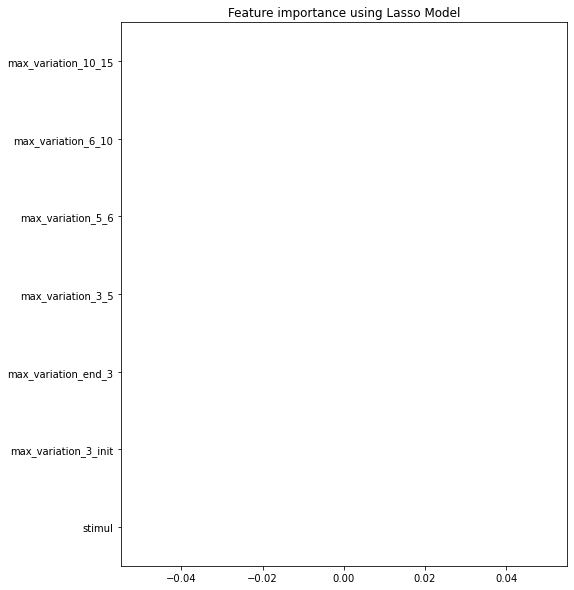

In [356]:
reg = LassoCV()
reg.fit(X_train, y_train)

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(X_train, y_train))
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [357]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[12,  8],
       [18, 14]], dtype=int64)

In [358]:
accuracy = accuracy_score(y_test, y_pred) * 100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

Accuracy of our model is equal 50.0 %.


In [359]:
scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.4f %% (+/- %0.4f)" % (scores.mean() * 100, (scores.std() * 2) * 100))

Accuracy: 64.9412 % (+/- 19.0661)


In [360]:
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
print("f1_macro: %0.4f %% (+/- %0.4f)" % (scores.mean() * 100, (scores.std() * 2) * 100))

f1_macro: 63.4010 % (+/- 21.3773)


In [361]:
# tests instances

label = {0: 'Alterado', 1: 'Atermo'}

x_test = dataset.copy()
x_test.pop('classify')
y_test = dataset.classify
log_execute = []
for index, value in x_test.iterrows():
    aux = value
    aux = aux.fillna(0)
    aux = (aux.to_numpy())
    pred = clf.predict([aux])
    pred = label[pred[0]]
    lab = label[y.iloc[index]]
    correct = 'CORRETO' if pred == lab else 'INCORRETO'
    log_execute.append("Registro {} index {} previsto: {}, label: {}!".format(index+1, correct, pred, lab))
    
with open('log_execute.txt', 'a') as file_writer:
    for line in log_execute:
        file_writer.write('{}\n'.format(line))

In [362]:
if replace_model:
    # Save model
    print('Save/Replace model!')
    from joblib import dump
    dump(clf, 'classify_KNN.joblib')

Save/Replace model!
